In [1]:
import datetime

import bs4
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import micplot

# Introduction

# Collecting the data

In [2]:
def url_to_soup(url):
    request = requests.get(url)
    return bs4.BeautifulSoup(request.text, 'html5lib')

def create_url(date):
    datestr = f'{date.day}-{date.month}-{date.year}'
    return f'https://www.muziekweb.nl/Muziekweb/Radio/?station=SkyRadio&date={datestr}&RangeStart=1&RangeEnd=500'

def find_all_rows(soup):
    return soup.find('ul', attrs={'class': 'radio-playlist'}).find_all('li', class_=['odd', 'even'])

def row_to_dct(ele) -> dict:
    result = {}
    result['Time'] = ele.find('div', attrs={'class': "col-time"}).text.strip()
    result['Title'] = ele.find('span', class_=['cat-songtitle', 'col-songtitle']).text.strip()
    result['Artist'] = ele.find('div', attrs={'class': "col-performers"}).text.strip()
    return result

def json_to_df(json, date):
    df = pd.DataFrame(json)
    df['Datetime'] = [pd.Timestamp(date.strftime('%Y-%m-%d ') + time) for time in df['Time']]
    return df.drop(columns=['Time'])


In [3]:
dfs = []
for date in pd.date_range('2022-11-01', '2022-12-25'):
    url = create_url(date)
    soup = url_to_soup(url)
    rows = find_all_rows(soup)
    json = [row_to_dct(div) for div in rows]
    df = json_to_df(json, date)
    dfs.append(df)

df = pd.concat(dfs)

# Analysis: when do the Christmas songs start playing?

In [4]:
df = df.assign(Hash = lambda df: df[['Title', 'Artist']].apply(lambda r: hash(tuple(r)), axis=1))
STARTDATE_CHRISTMASSTATION = '2022-12-06'
kerstnummer = df.groupby('Hash')['Datetime'].last().gt(STARTDATE_CHRISTMASSTATION)
df = df.assign(Kerstnummer = df['Hash'].map(kerstnummer))
df_song = df.groupby('Hash')[['Title', 'Artist']].first()

Text(0.5, 0, '')

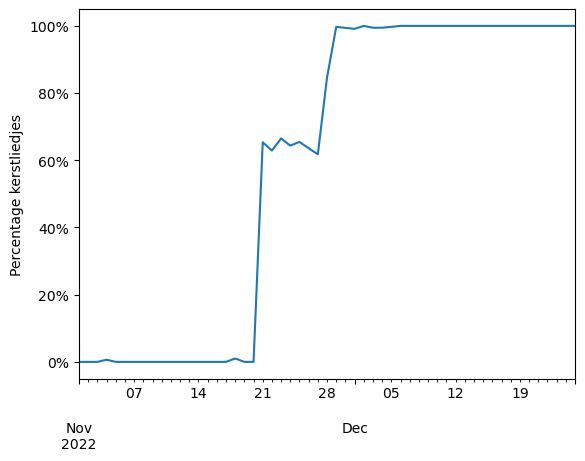

In [5]:
df_day = (df.groupby(pd.Grouper(key='Datetime', freq='D')).agg(AantalNummers = pd.NamedAgg('Hash', 'count'),
                                                                AantalUniekeNummers=pd.NamedAgg('Hash', 'nunique'),
                                                              VaakstGedraaid = pd.NamedAgg('Hash', lambda s: s.value_counts().max()),
                                                              PctKerstnummers = pd.NamedAgg('Kerstnummer', 'mean'),
)
.assign(GemiddeldKerenGedraaid = lambda df: df['AantalNummers'] / df['AantalUniekeNummers'])
)

ax = df_day['PctKerstnummers'].plot()
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_ylabel('Percentage kerstliedjes')
ax.set_xlabel('')

In [6]:
def filter_by_date_range(df, start_date, num_days):
  start_date = pd.to_datetime(start_date)
  end_date = start_date + pd.Timedelta(num_days, unit='d')
  mask = (df['Datetime'] >= start_date) & (df['Datetime'] < end_date)
  return df[mask]

def compare_unique_songs(df, days, first_start_date='2022-11-01', second_start_date='2022-12-01'):
    df_first_start_date = filter_by_date_range(df, first_start_date, days)
    df_second_start_date = filter_by_date_range(df, second_start_date, days)
    result = pd.Series({(first_start_date, days): df_first_start_date['Hash'].nunique(),
                (second_start_date, days): df_second_start_date['Hash'].nunique()})
    return result

df_nunique = (pd.concat([compare_unique_songs(df, d) for d in [1, 7, 20]])
                .unstack(level=0)
                .rename(columns={'2022-11-01': 'Pre-Christmas Period',
                                 '2022-12-01': 'Christmas Period'}
                                 )
              )


# Analysis: not many new songs are played

Text(0, 0.5, 'Number of songs')

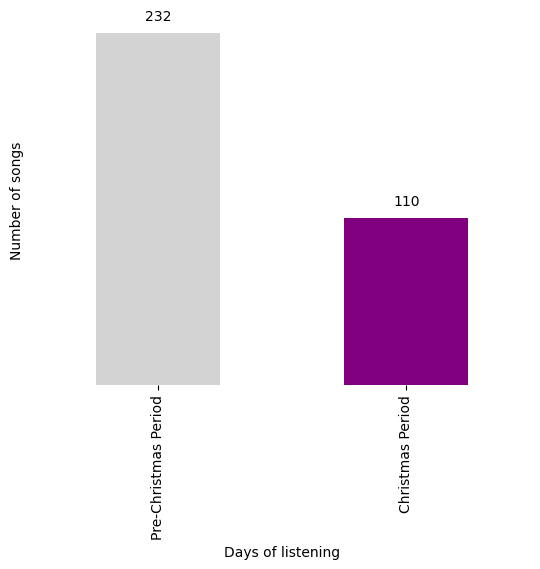

In [7]:
vis = micplot.visualize(df_nunique.loc[[1]], plottype='vertical_bar')
vis.ax.set_xlabel('Days of listening')
vis.ax.set_ylabel('Number of songs')

Text(0, 0.5, 'Number of songs')

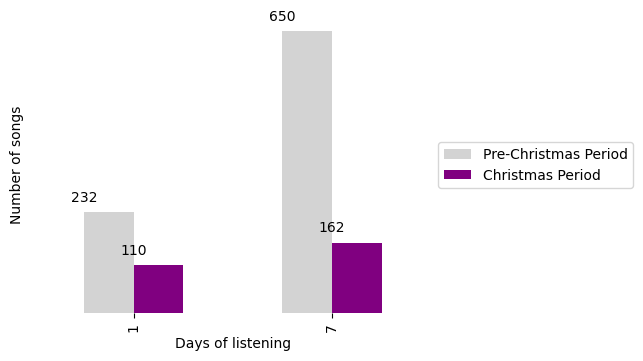

In [8]:
vis = micplot.visualize(df_nunique.loc[[1, 7]], plottype='vertical_bar')
vis.ax.set_xlabel('Days of listening')
vis.ax.set_ylabel('Number of songs')

Text(0, 0.5, 'Number of songs')

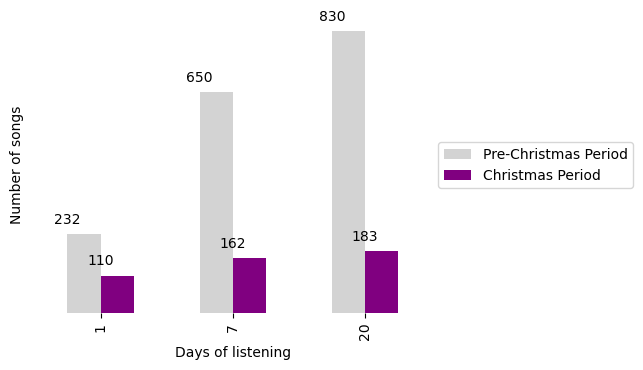

In [9]:
vis = micplot.visualize(df_nunique, plottype='vertical_bar')
vis.ax.set_xlabel('Days of listening')
vis.ax.set_ylabel('Number of songs')

In [10]:
songs_per_day = df.groupby([pd.Grouper(key='Datetime', freq='D'), 'Hash']).size()

# Analysis: a few favorite songs are replayed everytime

In [11]:
songs_per_day.loc[lambda s: s.eq(s.max())].to_frame(name='#_played').join(df_song)

#_played                       Title  \
Datetime   Hash                                                         
2022-12-24 -2030701603889322108         9               Santa tell me   
            2503988097722072517         9  Driving home for Christmas   
            5319227375646573972         9         Underneath the tree   
            7562222494269297604         9              Last Christmas   

                                         Artist  
Datetime   Hash                                  
2022-12-24 -2030701603889322108   Ariana Grande  
            2503988097722072517       Chris Rea  
            5319227375646573972  Kelly Clarkson  
            7562222494269297604           Wham!

In [12]:
songs_per_day.unstack(fill_value=0).loc['2022-12-01':].min().loc[lambda s: s.ge(5)].to_frame(name='min. # played every day').join(df_song)

,min. # played every day,Title,Artist
Hash,,,
-1983899554406624555,5,Happy x mas war is over,John Lennon
-562996564404392590,5,All I want for Christmas is you,Mariah Carey
373598356924467760,5,All alone on Christmas,Darlene Love
2503988097722072517,5,Driving home for Christmas,Chris Rea


This wasn't the case before Christmas

In [13]:
songs_per_day.unstack(fill_value=0).loc['2022-11-01':'2022-11-20'].min().loc[lambda s: s.ge(5)].to_frame(name='min. # played every day').join(df_song)

,min. # played every day,Title,Artist
Hash,,,


# Analysis: These songs amount to a serious percentage of all songs

In [14]:
n_played_dec = songs_per_day.loc['2022-12-01':].groupby('Hash').sum().sort_values(ascending=False)

(n_played_dec.cumsum() / n_played_dec.sum()).loc[lambda s: s<0.25].shape

(12,)

In [15]:
n_played_dec.to_frame().join(df_song).head(12)

,0,Title,Artist
Hash,,,
-562996564404392590,174,All I want for Christmas is you,Mariah Carey
7562222494269297604,172,Last Christmas,Wham!
2503988097722072517,171,Driving home for Christmas,Chris Rea
373598356924467760,170,All alone on Christmas,Darlene Love
-2030701603889322108,170,Santa tell me,Ariana Grande
9075625980769941621,169,Christmas time,Bryan Adams
5319227375646573972,169,Underneath the tree,Kelly Clarkson
1230657090513505592,168,Do they know it's Christmas,Band Aid
3310579603189762127,161,Thank God it's Christmas,Queen
